In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# Suppress warning messages
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000
# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [139]:
tmdls = pd.read_csv('all_actions.csv', parse_dates=['TMDLDate'], date_parser=lambda t: pd.to_datetime(t, errors='coerce')).drop('Unnamed: 0', axis=1).rename(columns={'assessmentUnitIdentifier':'AUID'})
huc_npdes_permit_links = pd.read_csv('huc_npdes_permit_links.csv', dtype={'attributes.WBD_HUC12': object}).rename(columns={'attributes.WBD_HUC12': 'HUC-12'})
huc_AUID_links = pd.read_csv('huc_AUID_links.csv', dtype={'attributes.huc12': object}).rename(columns={'attributes.assessmentunitidentifier':'AUID', 'attributes.huc12': 'HUC-12'})

In [140]:
len(tmdls.drop_duplicates('actionIdentifier'))

20009

In [141]:
tmdls_merged = tmdls.drop_duplicates().merge(huc_AUID_links, on='AUID', how='inner').merge(huc_npdes_permit_links, on='HUC-12', how='inner')
del tmdls
del huc_AUID_links
del huc_npdes_permit_links

## Method 1: incumbency determined by permit issuance date

In [158]:
permit_dates = pd.read_csv('permit_dates.csv', parse_dates=['effective_date','issue_date','original_effective_date','original_issue_date','expiration_date','retirement_date','termination_date'], date_parser=lambda t: pd.to_datetime(t, errors='coerce'))
# Drop permits without an issue date
permit_dates.dropna(subset='issue_date', inplace=True)

### Test state: Alabama

In [159]:
tmdls_merged_AL = tmdls_merged[tmdls_merged['state_code'] == 'AL']
tmdls_permits_merged = tmdls_merged_AL.merge(permit_dates, on='npdes_permit_id', how='inner')
del permit_dates

In [160]:
tmdls_permits_merged['incumbent'] = (tmdls_permits_merged['issue_date'] <= tmdls_permits_merged['TMDLDate'])

# Drop permits which expired/retired/terminated before the TMDL
tmdls_permits_merged = tmdls_permits_merged[~(tmdls_permits_merged['expiration_date'] <= tmdls_permits_merged['TMDLDate']) &
                                            ~(tmdls_permits_merged['retirement_date'] <= tmdls_permits_merged['TMDLDate']) &
                                            ~(tmdls_permits_merged['termination_date'] <= tmdls_permits_merged['TMDLDate'])]

In [161]:
# Read in DMR data for limit comparisons
AL_dmrs = pd.read_csv('~/Documents/DMR Work/DMR Python Projects/dmr-permit-limit-changes/dmr_data/AL_dmrs.csv')

In [162]:
# Extract only limits from DMR data
AL_limits = AL_dmrs.drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'parameter_desc', 'limit_value_type_code', 'limit_value_nmbr', 'statistical_base_code', 'limit_begin_date'])
del AL_dmrs
len(AL_limits)

460407

Let's first look at E. coli:

In [163]:
to_plot = AL_limits[AL_limits['parameter_desc']=='E. coli'].drop(['series_id', 'monitoring_period_end_date', 'monitoring_period_quarter_start', 'monitoring_period_quarter_end', 'monitoring_period_end_month', 'nmbr_of_submission', 'nmbr_of_report', 'dmr_unit_desc', 'dmr_unit_code', 'dmr_value_standard_units', 'value_received_date', 'value_received_month', 'value_received_quarter_start', 'value_received_quarter_end'], axis=1)
to_merge = tmdls_permits_merged[tmdls_permits_merged['pollutantName']=='ESCHERICHIA COLI (E. COLI)']
to_plot = to_plot.merge(to_merge[['npdes_permit_id', 'issue_date', 'incumbent', 'actionIdentifier', 'TMDLDate', 'AUID', 'HUC-12']])
plt.figure()
plt.hist(to_plot[to_plot['incumbent']==False].drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr'])['limit_value_nmbr'], label='Newcomers', bins=50, alpha=0.5);
plt.hist(to_plot[to_plot['incumbent']==True].drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr'])['limit_value_nmbr'], label='Incumbents', bins=50, alpha=0.5);
plt.legend()

KeyError: "['issue_date', 'incumbent'] not in index"

In [ ]:
to_plot = AL_limits[AL_limits['parameter_desc']=='pH']
to_merge = tmdls_merged_AL[tmdls_merged_AL['pollutantName']=='PH']
to_plot = to_plot.merge(to_merge[['npdes_permit_id', 'issue_date', 'incumbent', 'actionIdentifier', 'TMDLDate', 'AUID', 'HUC-12']]).drop(['series_id', 'monitoring_period_end_date', 'monitoring_period_quarter_start', 'monitoring_period_quarter_end', 'monitoring_period_end_month', 'nmbr_of_submission', 'nmbr_of_report', 'dmr_unit_desc', 'dmr_unit_code', 'dmr_value_standard_units', 'value_received_date', 'value_received_month', 'value_received_quarter_start', 'value_received_quarter_end'], axis=1)
plt.figure()
plt.hist(to_plot[to_plot['incumbent']==False].drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr'])['limit_value_nmbr'], label='Newcomers', bins=50, alpha=0.5);
plt.hist(to_plot[to_plot['incumbent']==True].drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr'])['limit_value_nmbr'], label='Incumbents', bins=50, alpha=0.5);
plt.legend()

In [ ]:
to_plot = AL_limits[AL_limits['parameter_desc']=='Solids, total suspended']
to_merge = tmdls_merged_AL[tmdls_merged_AL['pollutantName']=='TOTAL SUSPENDED SOLIDS (TSS)']
to_plot = to_plot.merge(to_merge[['npdes_permit_id', 'issue_date', 'incumbent', 'actionIdentifier', 'TMDLDate', 'AUID', 'HUC-12']]).drop(['series_id', 'monitoring_period_end_date', 'monitoring_period_quarter_start', 'monitoring_period_quarter_end', 'monitoring_period_end_month', 'nmbr_of_submission', 'nmbr_of_report', 'dmr_unit_desc', 'dmr_unit_code', 'dmr_value_standard_units', 'value_received_date', 'value_received_month', 'value_received_quarter_start', 'value_received_quarter_end'], axis=1)
plt.figure()
plt.hist(to_plot[to_plot['incumbent']==False].drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr'])['limit_value_nmbr'], label='Newcomers', bins=50, alpha=0.5);
plt.hist(to_plot[to_plot['incumbent']==True].drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr'])['limit_value_nmbr'], label='Incumbents', bins=50, alpha=0.5);
plt.legend()

In [ ]:
to_plot = AL_limits[AL_limits['parameter_desc'].apply(lambda x: x in ['Phosphorus, Total As P', 'Phosphorus, total [as P]', 'Phosphorous, total elemental', 'Phosphorous, total organic [as P]', 'Phosphorous, total recoverable'])]
to_merge = tmdls_merged_AL[tmdls_merged_AL['pollutantName']=='PHOSPHORUS, TOTAL']
to_plot = to_plot.merge(to_merge[['npdes_permit_id', 'issue_date', 'incumbent', 'actionIdentifier', 'TMDLDate', 'AUID', 'HUC-12']]).drop(['series_id', 'monitoring_period_end_date', 'monitoring_period_quarter_start', 'monitoring_period_quarter_end', 'monitoring_period_end_month', 'nmbr_of_submission', 'nmbr_of_report', 'dmr_unit_desc', 'dmr_unit_code', 'dmr_value_standard_units', 'value_received_date', 'value_received_month', 'value_received_quarter_start', 'value_received_quarter_end'], axis=1)
for value_type in to_plot['limit_value_type_code'].unique():
    plt.figure()
    plt.hist(to_plot[(to_plot['incumbent']==False) & (to_plot['limit_value_type_code']==value_type)].drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr'])['limit_value_nmbr'], label='Newcomers', bins=50, alpha=0.5);
    plt.hist(to_plot[(to_plot['incumbent']==True) & (to_plot['limit_value_type_code']==value_type)].drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr'])['limit_value_nmbr'], label='Incumbents', bins=50, alpha=0.5);
    plt.legend()
    plt.title('Phosphorus (' + value_type + ')')

## Method 2: Incumbency determined by limit begin date

In [167]:
tmdls_limits_merged = tmdls_merged_AL.merge(AL_limits.drop(['series_id', 'monitoring_period_end_date', 'monitoring_period_quarter_start', 'monitoring_period_quarter_end', 'monitoring_period_end_month', 'nmbr_of_submission', 'nmbr_of_report', 'dmr_unit_desc', 'dmr_unit_code', 'dmr_value_standard_units', 'value_received_date', 'value_received_month', 'value_received_quarter_start', 'value_received_quarter_end'], axis=1), on='npdes_permit_id', how='inner')

In [168]:
len(tmdls_limits_merged)

784579

In [171]:
tmdls_limits_merged['incumbent'] = (tmdls_limits_merged['limit_begin_date'] <= tmdls_limits_merged['TMDLDate'])

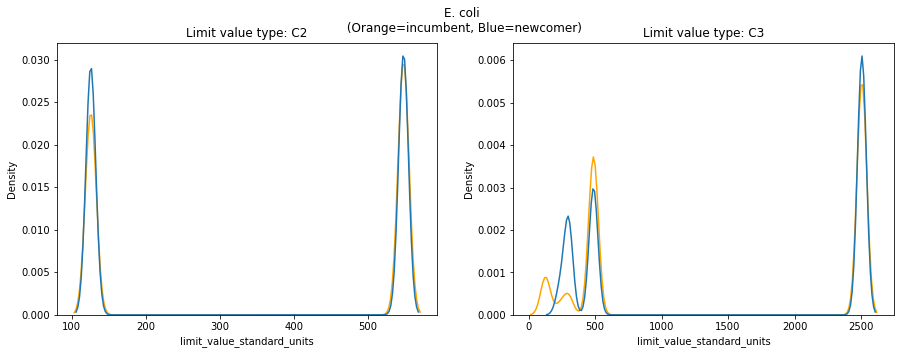

In [390]:
to_plot = tmdls_limits_merged[(tmdls_limits_merged['pollutantName']=='ESCHERICHIA COLI (E. COLI)') & (tmdls_limits_merged['parameter_desc']=='E. coli')].dropna(subset='limit_value_standard_units')

value_types = to_plot['limit_value_type_code'].unique()
fig, axes = plt.subplots(1, len(value_types), figsize=(15, 5))
fig.suptitle('E. coli' + '\n (Orange=incumbent, Blue=newcomer)')
for i in range(0, len(value_types)):
    sns.kdeplot(ax=axes[i], data=to_plot[(to_plot['incumbent']==True) & (to_plot['limit_value_type_code']==value_types[i])], x='limit_value_standard_units', bw_adjust=0.1, color='orange')
    sns.kdeplot(ax=axes[i], data=to_plot[(to_plot['incumbent']==False) & (to_plot['limit_value_type_code']==value_types[i])], x='limit_value_standard_units', bw_adjust=0.1)
    axes[i].set_title('Limit value type: ' + value_types[i])

In [180]:
tmdls_limits_merged['pollutantName'].unique()

array(['PHOSPHORUS, TOTAL', 'PH', 'LEAD', 'ESCHERICHIA COLI (E. COLI)',
       'FECAL COLIFORM', 'CARBONACEOUS BOD', 'NITROGENOUS BOD',
       'ENTEROCOCCUS BACTERIA', 'TOTAL SUSPENDED SOLIDS (TSS)',
       'ALUMINUM'], dtype=object)

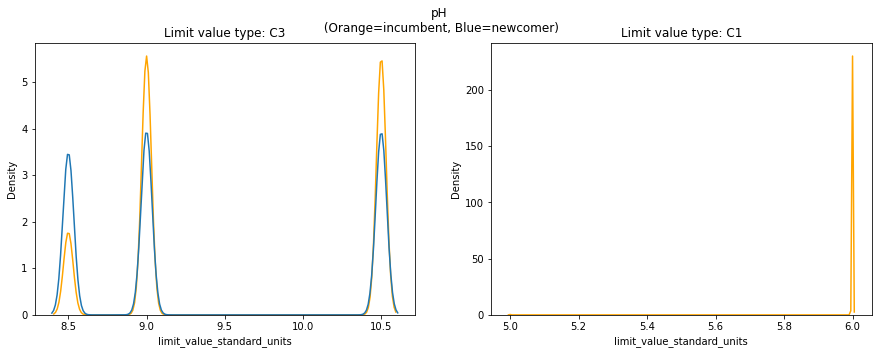

In [393]:
to_plot = tmdls_limits_merged[(tmdls_limits_merged['pollutantName']=='PH') & (tmdls_limits_merged['parameter_desc']=='pH')].dropna(subset='limit_value_standard_units')

value_types = to_plot['limit_value_type_code'].unique()
fig, axes = plt.subplots(1, len(value_types), figsize=(15, 5))
fig.suptitle('pH' + '\n (Orange=incumbent, Blue=newcomer)')
for i in range(0, len(value_types)):
    sns.kdeplot(ax=axes[i], data=to_plot[(to_plot['incumbent']==True) & (to_plot['limit_value_type_code']==value_types[i])], x='limit_value_standard_units', bw_adjust=0.2, color='orange')
    sns.kdeplot(ax=axes[i], data=to_plot[(to_plot['incumbent']==False) & (to_plot['limit_value_type_code']==value_types[i])], x='limit_value_standard_units', bw_adjust=0.2)
    axes[i].set_title('Limit value type: ' + value_types[i])

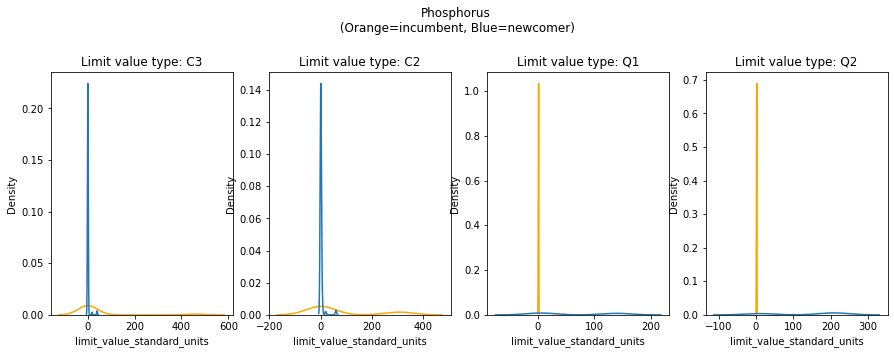

In [408]:
to_plot = tmdls_limits_merged[(tmdls_limits_merged['pollutantName']=='PHOSPHORUS, TOTAL') & (tmdls_limits_merged['parameter_desc'].apply(lambda x: x in ['Phosphorus, Total As P', 'Phosphorus, total [as P]', 'Phosphorous, total elemental', 'Phosphorous, total organic [as P]', 'Phosphorous, total recoverable']))].dropna(subset='limit_value_standard_units')

value_types = to_plot['limit_value_type_code'].unique()
fig, axes = plt.subplots(1, len(value_types), figsize=(15, 5))
fig.suptitle('Phosphorus' + '\n (Orange=incumbent, Blue=newcomer)')
for i in range(0, len(value_types)):
    sns.kdeplot(ax=axes[i], data=to_plot[(to_plot['incumbent']==True) & (to_plot['limit_value_type_code']==value_types[i])], x='limit_value_standard_units', bw_adjust=0.9, color='orange')
    sns.kdeplot(ax=axes[i], data=to_plot[(to_plot['incumbent']==False) & (to_plot['limit_value_type_code']==value_types[i])], x='limit_value_standard_units', bw_adjust=0.9)
    axes[i].set_title('Limit value type: ' + value_types[i])
fig.subplots_adjust(top=.8)

In [409]:
to_plot[(to_plot['incumbent']==False) & (to_plot['limit_value_type_code']=='Q1')]

,organizationIdentifier,organizationTypeText,state_code,actionIdentifier,actionTypeCode,actionStatusCode,completionDate,AUID,pollutantName,pollutantSourceTypeCode,explicitMarginofSafetyText,implicitMarginofSafetyText,TMDLEndPointText,TMDLDate,Unnamed: 0_x,HUC-12,Unnamed: 0_y,attributes.SOURCE_FEATUREID,npdes_permit_id,perm_feature_nmbr,parameter_desc,limit_id,limit_value_id,limit_begin_date,limit_end_date,limit_value_type_code,limit_value_nmbr,limit_value_standard_units,statistical_base_code,statistical_base_type_code,standard_unit_desc,value_type_code,incumbent
325284,21AWIC,State,AL,11567,TMDL,EPA Final Action,2008-10-28,AL03150106-0309-101,"PHOSPHORUS, TOTAL",Both,NaN,Y,NARRATIVE CRITERIA FOR NUTRIENTS. (TARGET MEAN...,2008-10-28,342919,031501060309,232,AL0002119001,AL0002119,001,"Phosphorus, total [as P]",1800012517,1800020573,2009-05-01 00:00:00,2012-05-31 00:00:00,Q1,305.94,138.896759,MK,AVG,kg/d,Q1,False
325301,21AWIC,State,AL,11567,TMDL,EPA Final Action,2008-10-28,AL03150106-0309-101,"PHOSPHORUS, TOTAL",Both,NaN,Y,NARRATIVE CRITERIA FOR NUTRIENTS. (TARGET MEAN...,2008-10-28,342919,031501060309,232,AL0002119001,AL0002119,001,"Phosphorus, total [as P]",3600793756,3601209666,2013-06-01 00:00:00,2018-05-31 00:00:00,Q1,13.34,6.056360,MK,AVG,kg/d,Q1,False
325320,21AWIC,State,AL,11567,TMDL,EPA Final Action,2008-10-28,AL03150106-0309-101,"PHOSPHORUS, TOTAL",Both,NaN,Y,NARRATIVE CRITERIA FOR NUTRIENTS. (TARGET MEAN...,2008-10-28,342919,031501060309,232,AL0002119001,AL0002119,001,"Phosphorus, total [as P]",3600793757,3601209670,2013-06-01 00:00:00,2018-05-31 00:00:00,Q1,305.94,138.896759,MK,AVG,kg/d,Q1,False
325358,21AWIC,State,AL,11567,TMDL,EPA Final Action,2008-10-28,AL03150106-0309-101,"PHOSPHORUS, TOTAL",Both,NaN,Y,NARRATIVE CRITERIA FOR NUTRIENTS. (TARGET MEAN...,2008-10-28,342919,031501060309,232,AL0002119001,AL0002119,001,"Phosphorus, total [as P]",3603642079,3606205876,2018-06-01 00:00:00,2023-05-31 00:00:00,Q1,13.34,6.056360,MK,AVG,kg/d,Q1,False
325382,21AWIC,State,AL,11567,TMDL,EPA Final Action,2008-10-28,AL03150106-0309-101,"PHOSPHORUS, TOTAL",Both,NaN,Y,NARRATIVE CRITERIA FOR NUTRIENTS. (TARGET MEAN...,2008-10-28,342919,031501060309,232,AL0002119001,AL0002119,001,"Phosphorus, total [as P]",3603642080,3606205880,2018-06-01 00:00:00,2023-05-31 00:00:00,Q1,305.94,138.896759,MK,AVG,kg/d,Q1,False
325487,21AWIC,State,AL,11567,TMDL,EPA Final Action,2008-10-28,AL03150106-0309-101,"PHOSPHORUS, TOTAL",Both,NaN,Y,NARRATIVE CRITERIA FOR NUTRIENTS. (TARGET MEAN...,2008-10-28,342919,031501060309,233,AL0002119002,AL0002119,001,"Phosphorus, total [as P]",1800012517,1800020573,2009-05-01 00:00:00,2012-05-31 00:00:00,Q1,305.94,138.896759,MK,AVG,kg/d,Q1,False
325504,21AWIC,State,AL,11567,TMDL,EPA Final Action,2008-10-28,AL03150106-0309-101,"PHOSPHORUS, TOTAL",Both,NaN,Y,NARRATIVE CRITERIA FOR NUTRIENTS. (TARGET MEAN...,2008-10-28,342919,031501060309,233,AL0002119002,AL0002119,001,"Phosphorus, total [as P]",3600793756,3601209666,2013-06-01 00:00:00,2018-05-31 00:00:00,Q1,13.34,6.056360,MK,AVG,kg/d,Q1,False
325523,21AWIC,State,AL,11567,TMDL,EPA Final Action,2008-10-28,AL03150106-0309-101,"PHOSPHORUS, TOTAL",Both,NaN,Y,NARRATIVE CRITERIA FOR NUTRIENTS. (TARGET MEAN...,2008-10-28,342919,031501060309,233,AL0002119002,AL0002119,001,"Phosphorus, total [as P]",3600793757,3601209670,2013-06-01 00:00:00,2018-05-31 00:00:00,Q1,305.94,138.896759,MK,AVG,kg/d,Q1,False
325561,21AWIC,State,AL,11567,TMDL,EPA Final Action,2008-10-28,AL03150106-0309-101,"PHOSPHORUS, TOTAL",Both,NaN,Y,NARRATIVE CRITERIA FOR NUTRIENTS. (TARGET MEAN...,2008-10-28,342919,031501060309,233,AL0002119002,AL0002119,001,"Phosphorus, total [as P]",3603642079,3606205876,2018-06-01 00:00:00,2023-05-31 00:00:00,Q1,13.34,6.056360,MK,AVG,kg/d,Q1,False
325585,21AWIC,State,AL,11567,TMDL,EPA Final Action,2008-10-28,AL03150106-0309-101,"PHOSPHORUS, TOTAL",Both,NaN,Y,NARRATIVE CRITERIA FOR NUTRIENTS. (TARGET MEAN...,2008-10-28,342919,031501060309,233,AL0002119002,AL0002119,001,"Phosphorus, t